In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import random
import re
import copy

# Targets:  
1. Word entropy  
2. Relative entropy of word structure  
3. TTR  
4. MTTR -זה לא קיים במאמר אבל הוא קיים, סוג של ממוצע נע של TTR

## 1. Word entrophy:  
чем больше спектр типов слов(спряжений и тп) тем больше информации упаковывается в слово нежели в словосочетание или предложение.  
T - text  
V - vocabulary of word types {w1,w2,w3,w4,..,wVV}
VV = |V|  
p(w) = Pr(T=w) for w in V   - probability of word type  

> #### The average information content of word types  
> H(T) = - sum( p(w_i) * log2(p(w_i)) ) from i=1 to VV


### James-Stein shrinkage estimator
> ~p(w_i)(shrink) = alpha * ~p(w_i)(target) + (1 - alpha) * ~p(w_i)(ML)  

\~p(w_i)(ML) - denotes the word probability according to the maximum likelihood account **max(~p(w))**   
alpha in [0,1] -  “shrinkage intensity”  
~p(w_i)(target) - “shrinkage target”  

maximum entropy case of auniform = p(w_i) = 1 / V

In [2]:
V = np.arange(0, 16, 1)  # types of word
T = [random.choice(V) for _ in range(100)]  # text with differend type of words

In [3]:
p = {x[0]:x[1]/len(T)   for x in np.transpose(np.unique(T, return_counts=True))} # probability of word type

In [4]:
ss = 0
for x in p:
    ss += p[x]
print(p) # all elements
print('sum', round(ss, 5)) # summ of all probabilities

{0: 0.06, 1: 0.1, 2: 0.02, 3: 0.07, 4: 0.07, 5: 0.05, 6: 0.05, 7: 0.08, 8: 0.05, 9: 0.1, 10: 0.04, 11: 0.07, 12: 0.09, 13: 0.07, 14: 0.02, 15: 0.06}
sum 1.0


#### James-Stein shrinkage estimator

In [5]:
alpha = 0.7
max_prob = p[max(p, key=p.get)] # maximum probability from our text
alpha_func = lambda x: round(alpha*x + (1-alpha)*max_prob, 5)

p_JS = {x:alpha_func(p[x]) for x in p}

In [6]:
print(p_JS)
print('sum', sum([p_JS[x] for x in p_JS]))

{0: 0.072, 1: 0.1, 2: 0.044, 3: 0.079, 4: 0.079, 5: 0.065, 6: 0.065, 7: 0.086, 8: 0.065, 9: 0.1, 10: 0.058, 11: 0.079, 12: 0.093, 13: 0.079, 14: 0.044, 15: 0.072}
sum 1.1800000000000002


### Average information content

In [7]:
def Word_entrophy(prob_dict):
    return round(-sum( prob_dict[word] * np.log2((prob_dict[word])) for word in prob_dict ), 5)

In [8]:
we_random_text = Word_entrophy(p)
weJS_random_text = Word_entrophy(p_JS)
print('WE:', we_random_text, '\nWE JS:', weJS_random_text,'\nrandom text std:', round(np.std(T), 4))
print('max probability:', max_prob, '\nmin probability:', p[min(p, key=p.get)])

WE: 3.88963 
WE JS: 4.39504 
random text std: 4.5184
max probability: 0.1 
min probability: 0.02


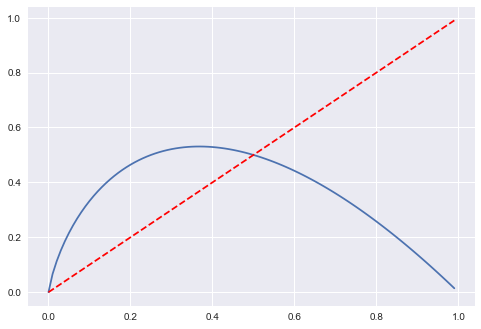

In [9]:
we_func = [-x*np.log2(x+0.00000000001) for x in np.arange(0, 1, 0.01)]
line = np.arange(0,1,0.01)
plt.plot( line, we_func)
plt.plot(line, line, 'r--')
# plt.plot(line,  aic_func - line, '.')
plt.show()

>### if all probabilities the same?

In [10]:
VV = 15
p_test = {x:round(1/VV, 4) for x in np.arange(1, VV+1, 1)}
print(p_test)
print('sum prob:', sum([p_test[x] for x in p_test]))
aic_test = Word_entrophy(p_test)
print('WE test:', aic_test, '\nprobability of 1 element =', p_test[1])

{1: 0.0667, 2: 0.0667, 3: 0.0667, 4: 0.0667, 5: 0.0667, 6: 0.0667, 7: 0.0667, 8: 0.0667, 9: 0.0667, 10: 0.0667, 11: 0.0667, 12: 0.0667, 13: 0.0667, 14: 0.0667, 15: 0.0667}
sum prob: 1.0005
WE test: 3.90812 
probability of 1 element = 0.0667


> ### half rare half often

In [11]:
VV = 15
ttt = np.ones((VV)) / VV * 2  # probabilities
ttt[int(np.ceil(VV/2)):] = 0.0001
p_test2 = {x:round(y,4) for x,y in zip(np.arange(1, VV+1, 1), ttt)}
print(p_test2)
print('sum prob:', round(sum([p_test2[x] for x in p_test2]), 4))
we_test2 = Word_entrophy(p_test2)
print('WE test:', we_test2, '\nmax probability:', p_test2[1], '\nmin probability:', p_test2[VV])

{1: 0.1333, 2: 0.1333, 3: 0.1333, 4: 0.1333, 5: 0.1333, 6: 0.1333, 7: 0.1333, 8: 0.1333, 9: 0.0001, 10: 0.0001, 11: 0.0001, 12: 0.0001, 13: 0.0001, 14: 0.0001, 15: 0.0001}
sum prob: 1.0671
WE test: 3.10959 
max probability: 0.1333 
min probability: 0.0001


# 2.Relative entropy of word structure

T - text drawn from alphabet A  
A = {c1,c2,c3,..cAA} - alphabet  
> ~H(T) = [ sum( l_i / log2(i+1) ) / n ]^-1 for i {1:n}

n - number of characters in text (T)  
l_i - is the length of the longest substring from position i onward that has not appeared before  
> ~D = ~H(T_masked) - ~H(T_orig)

T_masked - token of the same length but with characters randomly drawn with equal probability from the alphabet A

#### Universal Entropy of Word Ordering Across Linguistic Families  
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0019875

Let us consider a whole symbolic sequence of length n as , where i denotes any position inside the sequence. For every position i, there is a length, l_i, corresponding to the **~shortest~** contiguous subsequence that starts at position i, and does not appear in any continuous subsequence starting anywhere between position 1 and . For instance, consider the following alphabetical sequence: CDABCDEABCZ; at position 8, the shortest mismatch is l8 = 4. After parsing the whole sequence, the resulting series  will contain information about the redundancy in it

## Building random alphabet

In [12]:
A = [chr(x) for x in np.arange(97, 97+26, 1)] # Alphabet

In [13]:
def build_vocabulary(Alphabet, size, avr_len_word):
    Voc = []
    params = {'Alphabet':{x:0 for x in Alphabet}, 'Len_words': {}}
    while len(Voc) < size:
        len_word = max(int(random.normalvariate(avr_len_word, avr_len_word/3)), 1)
        new_word = ''.join(random.choice(A) for i in range(len_word))
        if new_word not in Voc:
            Voc.append(new_word)
            if len_word in params['Len_words']:
                params['Len_words'][len_word] += 1
            else:
                params['Len_words'][len_word] = 1
            for w in new_word:
                params['Alphabet'][w] += 1
    params['Len_words'] = dict(sorted(params['Len_words'].items()))
            
    return Voc, params

## Building random vocabulary

In [14]:
avr_len_word = 4
num_words = 200

V, voc_params = build_vocabulary(A, num_words, avr_len_word)
print(np.array(V))

['kpu' 'yyjuo' 'xyeyr' 'dub' 'qbp' 'sknui' 'rj' 'agcwr' 'm' 'twkoe' 'deft'
 'ymjp' 'ho' 'zuxz' 'cztbw' 'l' 'kcr' 'wlk' 'ubza' 'fkzkn' 'ohez' 'pbh'
 'rlteq' 'yvx' 'yz' 'yzf' 'lzii' 'ecl' 'vyk' 'txin' 'uit' 'zdv' 'tu'
 'gvthvm' 'nrzz' 'abda' 'd' 'gtnhz' 'vtf' 'ox' 'sumvm' 'gesd' 'cgyvo'
 'ogc' 'zwrkx' 'gyha' 'sis' 'yjll' 'quili' 'ekx' 'jtls' 'xwf' 'plsj'
 'tvxx' 'nje' 'aitb' 'srjbhr' 'eyfhk' 'yzid' 'fpje' 'ntx' 'azwp' 'lcor'
 'jeh' 'cdyb' 'rnj' 'wyy' 'ugn' 'c' 'nbq' 'fio' 'aj' 'tcy' 'fhdk' 'myoq'
 'bjvrvh' 'lh' 'ekolg' 'un' 'zcd' 'fspho' 'dfzg' 'byv' 'tg' 'hma' 'ql'
 'ck' 'pv' 'itpk' 'ruys' 'ofeeo' 'ucw' 'ysxrhq' 'ual' 'golom' 'cylj' 'uj'
 'scmly' 'szht' 'vhftu' 'i' 'abm' 'umjwa' 'mwrp' 'xbtcyw' 'pjzeco'
 'dutoni' 'icsj' 'hxleu' 'hqh' 'tsebe' 'mopq' 'kpyc' 'aovx' 'kwvdp' 'fdry'
 'kjfd' 'vdcw' 'vvynq' 'qm' 'khbiv' 'xvd' 'izavv' 'rkyi' 'aol' 'jopwb'
 'qt' 'shxo' 't' 'sed' 'qeo' 'hlf' 'lly' 'caeragd' 'ofgz' 'vm' 'mttg'
 'aflf' 'gjza' 'jheypm' 'xzjqtge' 'nmd' 'hcjn' 'lnpsb' 'znh' 'ndug' 'mna

In [15]:
print('Alphabet: ',voc_params['Alphabet'],'\nLen_words: ', voc_params['Len_words'])

Alphabet:  {'a': 24, 'b': 24, 'c': 32, 'd': 29, 'e': 33, 'f': 29, 'g': 25, 'h': 30, 'i': 24, 'j': 29, 'k': 25, 'l': 30, 'm': 28, 'n': 24, 'o': 31, 'p': 31, 'q': 20, 'r': 25, 's': 22, 't': 36, 'u': 27, 'v': 28, 'w': 21, 'x': 27, 'y': 36, 'z': 34} 
Len_words:  {1: 10, 2: 31, 3: 52, 4: 55, 5: 39, 6: 10, 7: 3}


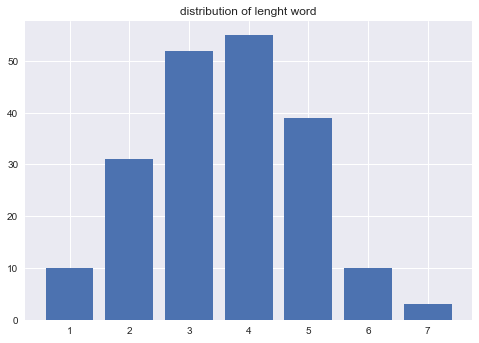

In [16]:
plt.bar(voc_params['Len_words'].keys(), voc_params['Len_words'].values())
plt.title('distribution of lenght word')
plt.xticks(np.arange(1, max(voc_params['Len_words'].keys())+1, 1))
plt.show()

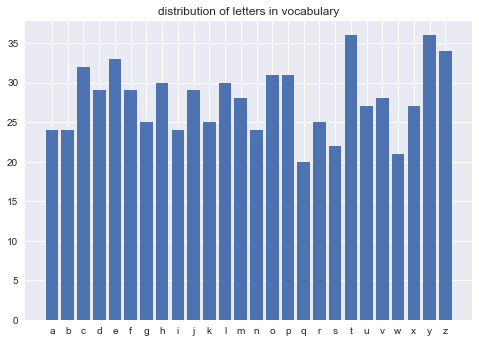

In [17]:
plt.bar(voc_params['Alphabet'].keys(), voc_params['Alphabet'].values())
plt.title('distribution of letters in vocabulary')
# plt.xticks(np.arange(1, max(voc_params['Len_words'].keys())+1, 1))
plt.show()

## Building random text

In [18]:
text_len = 250
T = [random.choice(V) for _ in range(text_len)]
pps = np.unique(T, return_counts=True)
words_frequency = {pps[0][i]:pps[1][i] for i in range(len(pps[0]))}
del(pps)

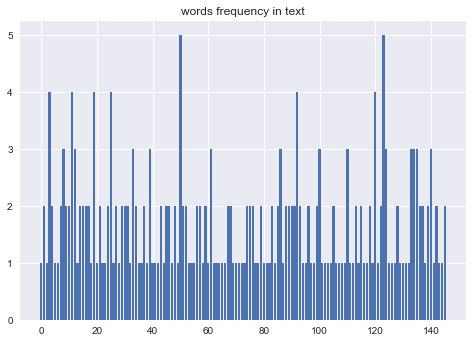

In [19]:
plt.bar(np.arange(0, len(words_frequency.keys()),1), words_frequency.values())
plt.title('words frequency in text')
# plt.xticks(np.arange(1, max(voc_params['Len_words'].keys())+1, 1))
plt.show()

In [20]:
def longest_substring(text):
    # last index of every character
    last_idx = {}
    max_len = 0
 
    # starting index of current 
    # window to calculate max_len
    start_idx = 0
 
    for i in range(0, len(string)):
       
        # Find the last index of str[i]
        # Update start_idx (starting index of current window)
        # as maximum of current value of start_idx and last
        # index plus 1
        if string[i] in last_idx:
            start_idx = max(start_idx, last_idx[string[i]] + 1)
 
        # Update result if we get a larger window
        max_len = max(max_len, i-start_idx + 1)
 
        # Update last index of current char.
        last_idx[string[i]] = i
 
    return max_len

def max_shortest_substring(text, i):
    max_len = 0
    start = 0
    exist = 1
    lenght = 0
    text_len = len(text)
    while True:
        while exist and (i + start + lenght) <= text_len:
            lenght += 1
            exist_old = exist
            exist = re.search(text[i + start: i + start + lenght], text[:i])
        if max_len < lenght and exist is None:
            max_len = lenght
#             print(text[exist_old.start():exist_old.end()])
        lenght = 0
        start += 1
        exist = 1
        if text_len - (i + start) < max_len:
            return max_len
            

def Relative_entropy(text):
    summ = 0
    text = ''.join(text).translate({ord(i): None for i in '“”<>,][.;:!?)/−(" '+"'"})
    print('00.00%', end='')
    for i in np.arange(0, len(text), 1):
        
        l = max_shortest_substring(text, i)  # max length of the shortest substring from position i onward that has not appeared before 
        summ += ( l / np.log2(i+1+1) )  # "i+1+1" in formula cicle from 1, we go from 0
        print('\r{:2.2f}%   char possition = {}'.format((i+1)/len(text)*100, i), end='')

    return pow(summ, -1)
        
def probability_char(text):
    text = ''.join(text).translate({ord(i): None for i in '“”<>,][.;:!?)/−(" '+"'"})
    char_counts = {}
    char_prob = {}
    for i in range(len(text)):
        if text[i] in char_counts:
            char_counts[text[i]] += 1
        else:
            char_counts[text[i]] = 1
    char_prob = {x:char_counts[x]/len(text) for x in char_counts}
    return char_prob, char_counts

def calc_probability_word(word, dict_prob):
    summ = 0
    for w in word:
        summ += dict_prob[w]
    return summ

def make_random_copy_text(text):
    prob_char,_ = probability_char(text)
    text = text.translate({ord(i): None for i in '“”<>,][.;:!?)/−("'+"'"}).split(' ')
    text_c = copy.deepcopy(text)
    
    chars = [x for x in prob_char]
    
    prob_dev = 0.1
    for i in range(len(text)):
        word_prob = calc_probability_word(text[i], prob_char)
        new_word_prob = 0
        
        while new_word_prob < word_prob*(1-prob_dev) or new_word_prob > word_prob*(1 + prob_dev):
            new_word = ''
            new_word_prob = 0
            for l in range(len(text[i])):
                new_char = random.choice(chars)
                new_word += new_char
                new_word_prob += prob_char[new_char]
                
        text_c[i] = new_word
    return text_c
            

In [21]:
text = '''Let us consider a whole symbolic sequence of length n as , where i denotes any position inside the sequence. 
        For every position i, there is a length, l_i, corresponding to the shortest contiguous subsequence that starts at position i, 
        and does not appear in any continuous subsequence starting anywhere'''

In [22]:
RE = Relative_entropy(text)
RE

100.00%   char possition = 248

0.0026561961925050926

In [23]:
RE_masked = Relative_entropy(make_random_copy_text(text))
RE_masked

100.00%   char possition = 264

0.004206898935339619

In [24]:
D = RE_masked - RE
D

0.0015507027428345263

# 3. TTR - Type/Token ratios

> C_TTR = V / ( summ(fr_i) )

V - number of all types of words(tokens)  
fr - frequency of i type

In [30]:
from nltk.tokenize import word_tokenize
text = "God is Great! I won a lottery. and want to win more, wanted"
print(word_tokenize(text))

['God', 'is', 'Great', '!', 'I', 'won', 'a', 'lottery', '.', 'and', 'want', 'to', 'win', 'more', ',', 'wanted']


In [45]:
def TTR(text):
    text = text.translate({ord(i): None for i in '“”<>,][.;:!?)/−("'+"'"}).split(' ')
    pps = np.unique(text, return_counts=True)
    return len(pps[0])/sum(pps[1])
    

In [49]:
TTR(' '.join(T))

0.584

# 4. MATTR: TTR + window

In [58]:
def MATTR(text, window):
    pos = 0
    result = 0
    while pos + window <= len(text):
        result += TTR(text[pos: pos+window])
        pos += 1
    return result/pos

In [59]:
MATTR(' '.join(T), 500)

0.7948323298559323